In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option('max_colwidth', 5000)
from IPython.display import display
from sklearn.model_selection import train_test_split as tts

## Load Data From CSV File

First thing is merging the csv file into one file <br />
Here is the code:
`cat *.csv >merged.csv`
<br/>
**Note:** to read the csv file in, need to do `skiprows=1` and `low_memory=False`

<br/>
Next, take a look at the data. Simple command to explore the data so I can explore over time

In [2]:
df_backup = pd.read_csv('/Users/fayadabbasi/Desktop/Python_Scripts/Galvanize/DSI/CreditRisk/merged.csv', skiprows=1, low_memory=False)

In [3]:
df = df_backup.copy()

### First Modification
Since I have the merged `.csv` files, I need to drop the redundant rows
<br/>
There should be 16 of them

In [4]:
df = df[df.id!='id'] # leave behind those that do not have id in the id column
# due to csv merge, need to eliminate rows with redundant index; 16 of these

### Next, Check Loan Status
Want to see loan_status counts

In [5]:
df.loan_status.value_counts()

Fully Paid                                             1191125
Current                                                 868848
Charged Off                                             287174
Late (31-120 days)                                       20775
In Grace Period                                           9242
Late (16-30 days)                                         4826
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     42
Name: loan_status, dtype: int64

Create a dataframe with the most likely fields to analyze for loan performance
<br/>
Note that I can look at a variety of items in the future but this is initial analysis.

In [6]:
df = df[['loan_amnt','grade','emp_length','annual_inc','purpose','revol_util','home_ownership','term','int_rate','loan_status','open_acc','zip_code','tot_cur_bal','tot_coll_amt']]

In [7]:
potential_list = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership','annual_inc','verification_status','issue_d','pymnt_plan','purpose','addr_state','dti','delinq_2yrs','earliest_credit_line','inq_last_6mths','mths_since_last_delinq','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee']

In [8]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,loan_status,open_acc,zip_code,tot_cur_bal,tot_coll_amt
0,5000,B,10+ years,24000,credit_card,83.7%,RENT,36 months,10.65%,Fully Paid,3,860xx,NaN,NaN
1,2500,C,< 1 year,30000,car,9.4%,RENT,60 months,15.27%,Charged Off,3,309xx,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384832 entries, 0 to 2384847
Data columns (total 14 columns):
loan_amnt         object
grade             object
emp_length        object
annual_inc        object
purpose           object
revol_util        object
home_ownership    object
term              object
int_rate          object
loan_status       object
open_acc          object
zip_code          object
tot_cur_bal       object
tot_coll_amt      object
dtypes: object(14)
memory usage: 272.9+ MB


### Preprocessing

First convert object items to numeric - only two fields
<br/>
Then apply my universal preprocessing function to do broader cleaning

In [10]:
convert_to_numeric = ['loan_amnt','annual_inc','open_acc','tot_cur_bal','tot_coll_amt']
for items in convert_to_numeric:
    df[items] = pd.to_numeric(df[items])

In [11]:
def pre_processing(dataframe, date='2019-8-01'):
    def emp_length(dataframe,column='emp_length'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'].replace('< 1 year', 0, inplace=True)
        dataframe[column+'_int'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
        dataframe[column+'_int'].fillna(value=0, inplace=True)
    
    def term_length(dataframe, column='term'):
        dataframe[column+'_int'] = dataframe[column]
        dataframe[column+'_int'] = dataframe[column].str.replace(' months','')
        dataframe[column+'_int'] = pd.to_numeric(dataframe[column+'_int'])
    
    def perc_convert(dataframe, column):
        dataframe[column+'_t'] = dataframe[column].fillna(str('0'))
        dataframe[column+'_factor'] = dataframe[column+'_t'].map(lambda x: str(x).rstrip('%').strip())
        dataframe[column+'_factor'] = pd.to_numeric(dataframe[column+'_factor'])
    
    def zip_convert(dataframe, column):
        dataframe[column+'_t'] = dataframe[column].fillna(str('000'))
        dataframe[column+'_t'] = dataframe[column+'_t'].map(lambda x: str(x).rstrip('xx').strip())
        dataframe[column+'_t'] = pd.to_numeric(dataframe[column+'_t'])
    
    emp_length(dataframe)
    term_length(dataframe)
    perc_convert(dataframe, column='int_rate')
    perc_convert(dataframe, column='revol_util')
    zip_convert(dataframe, column='zip_code')
    
    dataframe['annual_inc'].fillna(dataframe['annual_inc'].mean(), inplace=True)
    dataframe['good_bad'] = np.where(dataframe['loan_status'].isin(['Charged Off','Default','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Late (31-120 days)','Late (16-30 days)']),0,1)
    
    
    return dataframe

In [12]:
df = pre_processing(df)

In [13]:
df.head(2)

,loan_amnt,grade,emp_length,annual_inc,purpose,revol_util,home_ownership,term,int_rate,loan_status,...,tot_cur_bal,tot_coll_amt,emp_length_int,term_int,int_rate_t,int_rate_factor,revol_util_t,revol_util_factor,zip_code_t,good_bad
0,5000.0,B,10+ years,24000.0,credit_card,83.7%,RENT,36 months,10.65%,Fully Paid,...,NaN,NaN,10.0,36.0,10.65%,10.65,83.7%,83.7,860,1
1,2500.0,C,< 1 year,30000.0,car,9.4%,RENT,60 months,15.27%,Charged Off,...,NaN,NaN,0.0,60.0,15.27%,15.27,9.4%,9.4,309,0


In [14]:
df = df.drop(['emp_length','term','int_rate','int_rate_t','revol_util','revol_util_t', 'zip_code'], axis=1)

In [15]:
def missing_values(dataframe,column):
    for items in column:
        dataframe = dataframe[dataframe[items].notnull()]
    return dataframe

In [16]:
df = missing_values(df,['loan_amnt','tot_cur_bal','tot_coll_amt']) 

In [17]:
def null_values(d):
    mis_valu = d.isnull().sum()
    mis_val_percent = 100* d.isnull().sum() / len(d)
    mis_val_table = pd.concat([mis_valu, mis_val_percent],axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(d.shape[1]) + " columns.\nThere are "+ str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

In [18]:
miss_values = null_values(df)

Dataframe has 15 columns.
There are 0 columns that have missing values.


In [19]:
df.head(2)

,loan_amnt,grade,annual_inc,purpose,home_ownership,loan_status,open_acc,tot_cur_bal,tot_coll_amt,emp_length_int,term_int,int_rate_factor,revol_util_factor,zip_code_t,good_bad
42540,12000.0,A,96500.0,debt_consolidation,MORTGAGE,Fully Paid,17.0,200314.0,0.0,3.0,36.0,7.62,55.7,782,1
42541,27050.0,B,55000.0,debt_consolidation,OWN,Fully Paid,14.0,114834.0,0.0,10.0,36.0,10.99,61.2,481,1


### View a few plots

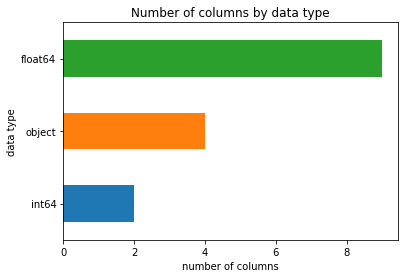

In [20]:
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns by data type')
plt.xlabel("number of columns")
plt.ylabel("data type");

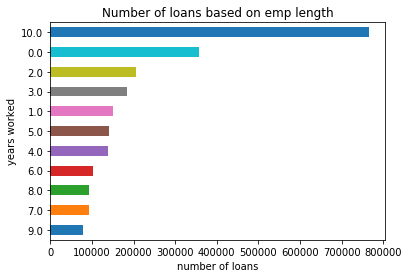

In [21]:
df['emp_length_int'].value_counts().sort_values().plot(kind='barh')
plt.title('Number of loans based on emp length')
plt.xlabel('number of loans')
plt.ylabel('years worked');

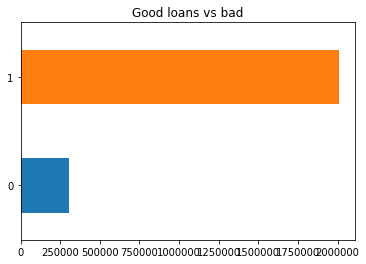

In [22]:
df.good_bad.value_counts().sort_values().plot(kind='barh')
plt.title('Good loans vs bad');

### Create One Hot Encoding for Categorical Items
There are 5 columns that are already in categorical form

In [23]:
lst = ['grade','home_ownership','purpose','emp_length_int','term_int']
def loan_data_d(dataframe, lst = []):
    for items in lst:
        loan_data_dummies = [pd.get_dummies(dataframe[items], prefix=items,prefix_sep=':')]
        loan_data_dummies = pd.concat(loan_data_dummies, axis=1)
        dataframe = pd.concat([dataframe, loan_data_dummies], axis = 1)
    return dataframe

In [24]:
df = loan_data_d(df,lst)

In [25]:
df = df.drop(lst, axis=1)

In [26]:
df.head(2)

,loan_amnt,annual_inc,loan_status,open_acc,tot_cur_bal,tot_coll_amt,int_rate_factor,revol_util_factor,zip_code_t,good_bad,...,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
42540,12000.0,96500.0,Fully Paid,17.0,200314.0,0.0,7.62,55.7,782,1,...,1,0,0,0,0,0,0,0,1,0
42541,27050.0,55000.0,Fully Paid,14.0,114834.0,0.0,10.99,61.2,481,1,...,0,0,0,0,0,0,0,1,1,0


In [27]:
df['loan_status'].value_counts() / df['loan_status'].count()

Fully Paid            0.489917
Current               0.375393
Charged Off           0.119618
Late (31-120 days)    0.008976
In Grace Period       0.003993
Late (16-30 days)     0.002085
Default               0.000018
Name: loan_status, dtype: float64

### Create Train Test Split

In [28]:
loan_data_input_train, loan_data_input_test, loan_data_target_train, loan_data_target_test = tts(df.drop(['loan_status','good_bad'], axis=1), df['good_bad'], test_size=0.25, random_state=42)

In [29]:
loan_data_input_train_2, loan_data_input_test_2, loan_data_target_train_2, loan_data_target_test_2 = tts(df.drop(['loan_status','good_bad'], axis=1), df['good_bad'], test_size=0.25, random_state=42)

In [30]:
df_inputs_prepr, df_targets_prepr = loan_data_input_train, loan_data_target_train

### Create One Hot Encoding for Continuous Variables
Will do a Weight of Evidence to see how to break down continuous variables to bins based on WoE

In [31]:
def woe_ordered_continuous(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1-df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good']/ df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # df = df.sort_values(['WoE'])
    # df = df.reset_index(drop=True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [32]:
df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],30)
#df_inputs_prepr['loan_amnt_factor'] = pd.cut(df_inputs_prepr['loan_amnt'],5).astype(str)
# df_inputs_prepr.loan_amnt_factor[0].replace('(','').replace(']','').replace(' ','').split(',')[1]

In [33]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'loan_amnt_factor',df_targets_prepr)
df_temp

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(961.0, 2300.0]",36937,0.909359,0.021279,33589.0,3348.0,0.022257,0.014765,0.410371,NaN,NaN,0.034961
1,"(2300.0, 3600.0]",63107,0.899266,0.036355,56750.0,6357.0,0.037604,0.028036,0.293635,0.010093,0.116736,0.034961
2,"(3600.0, 4900.0]",55966,0.886074,0.032241,49590.0,6376.0,0.032860,0.028120,0.155784,0.013193,0.137851,0.034961
3,"(4900.0, 6200.0]",149263,0.890750,0.085987,132956.0,16307.0,0.088101,0.071918,0.202959,0.004676,0.047176,0.034961
4,"(6200.0, 7500.0]",79637,0.882291,0.045877,70263.0,9374.0,0.046559,0.041342,0.118841,0.008459,0.084118,0.034961
5,"(7500.0, 8800.0]",89284,0.877492,0.051434,78346.0,10938.0,0.051915,0.048239,0.073427,0.004799,0.045413,0.034961
6,"(8800.0, 10100.0]",200069,0.881256,0.115255,176312.0,23757.0,0.116830,0.104774,0.108913,0.003764,0.035486,0.034961
7,"(10100.0, 11400.0]",53555,0.848063,0.030852,45418.0,8137.0,0.030095,0.035886,-0.175978,0.033193,0.284891,0.034961
8,"(11400.0, 12700.0]",115761,0.862778,0.066687,99876.0,15885.0,0.066181,0.070057,-0.056910,0.014715,0.119067,0.034961
9,"(12700.0, 14000.0]",65168,0.859870,0.037542,56036.0,9132.0,0.037131,0.040274,-0.081255,0.002908,0.024345,0.034961


In [34]:
def plot_by_woe(df_WoE, rotation_of_x_axis_label=0):
    x = np.array(df_WoE.iloc[:,0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y,marker='o', linestyle='--',color='k')
    plt.xlabel = (df_WoE.columns[0])
    plt.ylabel = ('Weight of Evidence')
    plt.title(str('Weight of Evidence by '+ df_WoE.columns[0]))
    plt.xticks(rotation=rotation_of_x_axis_label)

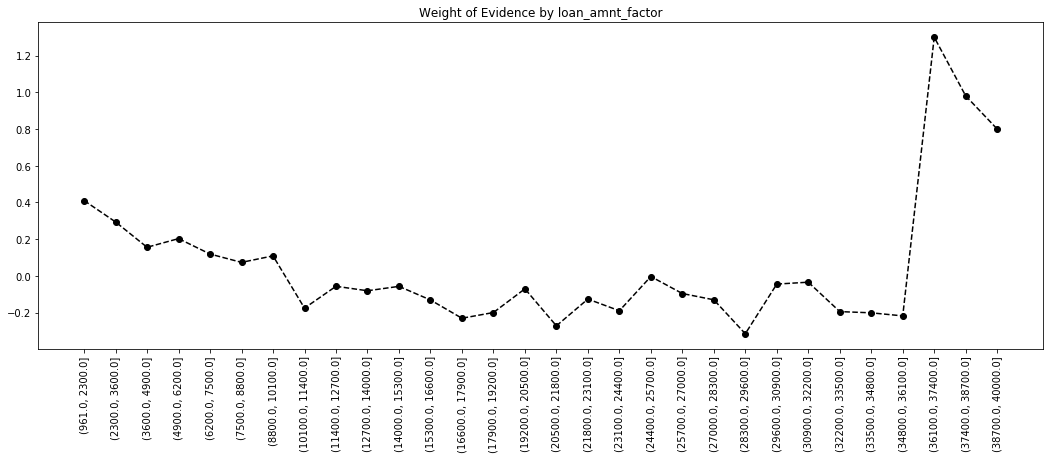

In [35]:
plot_by_woe(df_temp, 90)

In [36]:
df_inputs_prepr['loan_amnt_factor:1'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817))),1,0)
df_inputs_prepr['loan_amnt_factor:2'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(1817,7084))),1,0)
df_inputs_prepr['loan_amnt_factor:3'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(7084,11034))),1,0)
df_inputs_prepr['loan_amnt_factor:4'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(11034,28150))),1,0)
df_inputs_prepr['loan_amnt_factor:5'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28150,28160))),1,0)
df_inputs_prepr['loan_amnt_factor:6'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(28160,32100))),1,0)
df_inputs_prepr['loan_amnt_factor:7'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(32100,36050))),1,0)
df_inputs_prepr['loan_amnt_factor:8'] = np.where((df_inputs_prepr['loan_amnt_factor'].isin(range(36050,int(df_inputs_prepr['loan_amnt'].max())))),1,0)

In [37]:
df_inputs_prepr.head(2)

,loan_amnt,annual_inc,open_acc,tot_cur_bal,tot_coll_amt,int_rate_factor,revol_util_factor,zip_code_t,grade:A,grade:B,...,term_int:60.0,loan_amnt_factor,loan_amnt_factor:1,loan_amnt_factor:2,loan_amnt_factor:3,loan_amnt_factor:4,loan_amnt_factor:5,loan_amnt_factor:6,loan_amnt_factor:7,loan_amnt_factor:8
1481818,6000.0,56000.0,8.0,2221.0,327.0,11.49,19.3,112,0,1,...,0,"(4900.0, 6200.0]",0,1,0,0,0,0,0,0
2287801,11000.0,50717.0,8.0,187118.0,0.0,12.40,32.6,836,0,1,...,1,"(10100.0, 11400.0]",0,0,1,1,0,0,0,0


In [38]:
df_inputs_prepr = df_inputs_prepr.drop(['loan_amnt', 'loan_amnt_factor'], axis=1)

In [39]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'],100)

In [40]:
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc']<140000,:]

In [41]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'],20)

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
df_temp = woe_ordered_continuous(df_inputs_prepr_temp,'annual_inc_factor',df_targets_prepr[df_inputs_prepr_temp.index])
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-139.999, 6999.95]",2608,0.924463,0.001648,2411.0,197.0,0.001760,0.000927,0.641240,NaN,NaN,0.02224
1,"(6999.95, 13999.9]",7464,0.857583,0.004718,6401.0,1063.0,0.004674,0.005002,-0.067994,0.066880,0.709234,0.02224
2,"(13999.9, 20999.85]",24289,0.843756,0.015352,20494.0,3795.0,0.014963,0.017859,-0.176906,0.013827,0.108911,0.02224
3,"(20999.85, 27999.8]",51409,0.841253,0.032493,43248.0,8161.0,0.031576,0.038405,-0.195769,0.002503,0.018863,0.02224
4,"(27999.8, 34999.75]",89700,0.842642,0.056695,75585.0,14115.0,0.055186,0.066423,-0.185334,0.001389,0.010436,0.02224
5,"(34999.75, 41999.7]",148093,0.847643,0.093603,125530.0,22563.0,0.091652,0.106178,-0.147120,0.005001,0.038214,0.02224
6,"(41999.7, 48999.65]",145286,0.849621,0.091829,123438.0,21848.0,0.090125,0.102814,-0.131724,0.001978,0.015396,0.02224
7,"(48999.65, 55999.6]",181212,0.857029,0.114536,155304.0,25908.0,0.113391,0.121919,-0.072521,0.007409,0.059203,0.02224
8,"(55999.6, 62999.55]",148091,0.860768,0.093602,127472.0,20619.0,0.093070,0.097030,-0.041670,0.003739,0.030851,0.02224
9,"(62999.55, 69999.5]",117075,0.864412,0.073998,101201.0,15874.0,0.073889,0.074701,-0.010928,0.003644,0.030742,0.02224


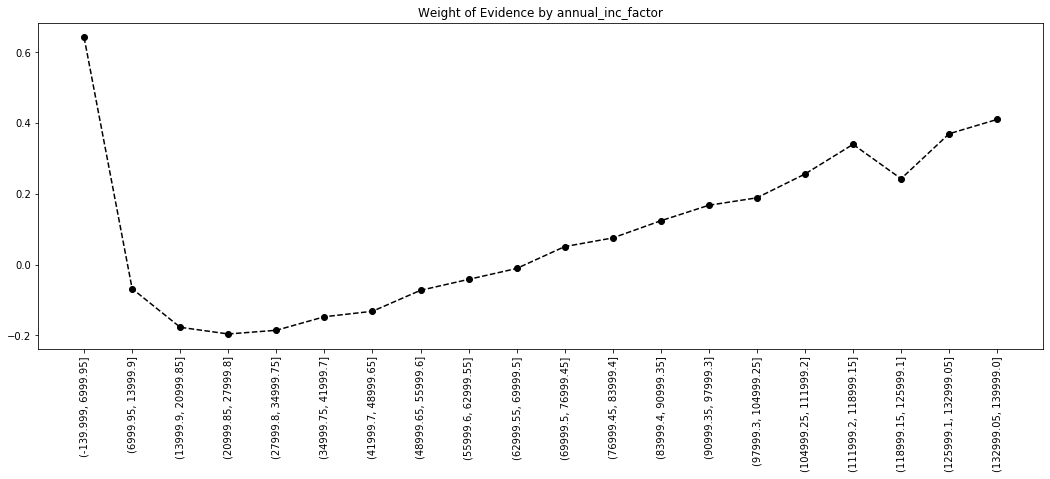

In [43]:
plot_by_woe(df_temp, 90)

In [44]:
df_inputs_prepr['annual_inc_factor:1'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000))),1,0)
df_inputs_prepr['annual_inc_factor:2'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(7000,42000))),1,0)
df_inputs_prepr['annual_inc_factor:3'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(42000,70000))),1,0)
df_inputs_prepr['annual_inc_factor:4'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(70000,100000))),1,0)
df_inputs_prepr['annual_inc_factor:5'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(100000,112000))),1,0)
df_inputs_prepr['annual_inc_factor:6'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(112000,126000))),1,0)
df_inputs_prepr['annual_inc_factor:7'] = np.where((df_inputs_prepr['annual_inc_factor'].isin(range(126000,int(df_inputs_prepr['annual_inc'].max())))),1,0)

In [45]:
df_inputs_prepr = df_inputs_prepr.drop(['annual_inc','annual_inc_factor'], axis=1)

In [46]:
df_inputs_prepr['int_rate_factor_f'] = pd.cut(df_inputs_prepr['int_rate_factor'],10)

In [47]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'int_rate_factor_f',df_targets_prepr)
df_temp

,int_rate_factor_f,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.284, 7.878]",241628,0.968919,0.139196,234118.0,7510.0,0.155134,0.033121,1.544125,NaN,NaN,0.438053
1,"(7.878, 10.446]",310962,0.931541,0.179138,289674.0,21288.0,0.191947,0.093885,0.715148,0.037378,0.828977,0.438053
2,"(10.446, 13.014]",398880,0.887477,0.229786,353997.0,44883.0,0.234570,0.197945,0.169765,0.044064,0.545383,0.438053
3,"(13.014, 15.582]",314143,0.852503,0.180971,267808.0,46335.0,0.177458,0.204348,-0.141092,0.034974,0.310857,0.438053
4,"(15.582, 18.15]",222721,0.806736,0.128305,179677.0,43044.0,0.119060,0.189834,-0.466527,0.045768,0.325435,0.438053
5,"(18.15, 20.718]",124081,0.764944,0.071480,94915.0,29166.0,0.062894,0.128629,-0.715486,0.041792,0.248960,0.438053
6,"(20.718, 23.286]",58665,0.739299,0.033796,43371.0,15294.0,0.028739,0.067450,-0.853134,0.025644,0.137648,0.438053
7,"(23.286, 25.854]",39503,0.708680,0.022757,27995.0,11508.0,0.018550,0.050753,-1.006481,0.030619,0.153347,0.438053
8,"(25.854, 28.422]",13418,0.689447,0.007730,9251.0,4167.0,0.006130,0.018377,-1.097929,0.019233,0.091448,0.438053
9,"(28.422, 30.99]",11877,0.701103,0.006842,8327.0,3550.0,0.005518,0.015656,-1.042909,0.011656,0.055020,0.438053


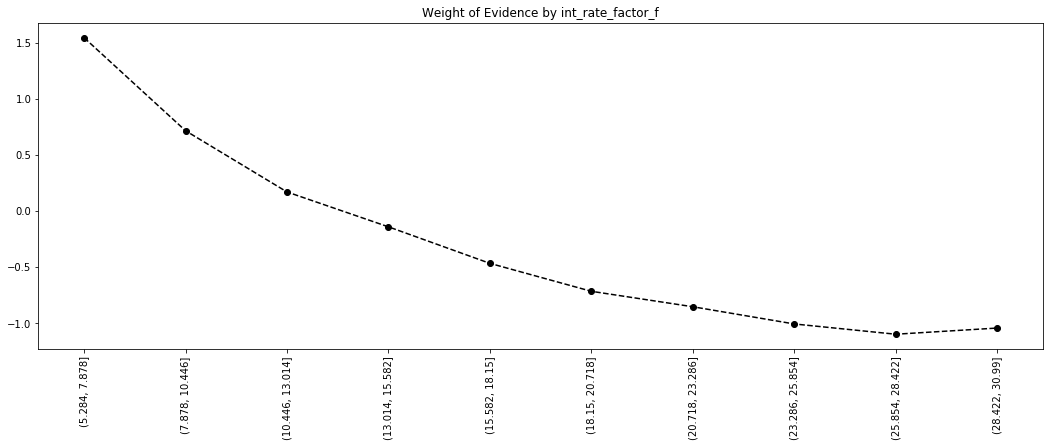

In [48]:
plot_by_woe(df_temp, 90)

In [49]:
df_inputs_prepr['int_rate_factor:1'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(8))),1,0)
df_inputs_prepr['int_rate_factor:2'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(8,11))),1,0)
df_inputs_prepr['int_rate_factor:3'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(11,13))),1,0)
df_inputs_prepr['int_rate_factor:4'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(13,15))),1,0)
df_inputs_prepr['int_rate_factor:5'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(15,17))),1,0)
df_inputs_prepr['int_rate_factor:6'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(17,19))),1,0)
df_inputs_prepr['int_rate_factor:7'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(19,21))),1,0)
df_inputs_prepr['int_rate_factor:8'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(21,23))),1,0)
df_inputs_prepr['int_rate_factor:9'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(23,25))),1,0)
df_inputs_prepr['int_rate_factor:10'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(25,27))),1,0)
df_inputs_prepr['int_rate_factor:11'] = np.where((df_inputs_prepr['int_rate_factor_f'].isin(range(27,int(df_inputs_prepr['int_rate_factor'].max())))),1,0)

In [50]:
df_inputs_prepr = df_inputs_prepr.drop(['int_rate_factor','int_rate_factor_f'], axis=1)

In [51]:
df_inputs_prepr['revol_util_factor_f'] = pd.cut(df_inputs_prepr['revol_util_factor'],30)

In [52]:
df_temp = woe_ordered_continuous(df_inputs_prepr,'revol_util_factor_f',df_targets_prepr)
df_temp

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


,revol_util_factor_f,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.892, 29.743]",411290,0.901442,2.369349e-01,370754.0,40536.0,2.456735e-01,0.178774,0.317884,NaN,NaN,inf
1,"(29.743, 59.487]",691609,0.869377,3.984203e-01,601269.0,90340.0,3.984202e-01,0.398421,-0.000002,0.032065,0.317886,inf
2,"(59.487, 89.23]",530600,0.849947,3.056666e-01,450982.0,79618.0,2.988352e-01,0.351135,-0.161277,0.019430,0.161275,inf
3,"(89.23, 118.973]",102234,0.841364,5.889469e-02,86016.0,16218.0,5.699696e-02,0.071525,-0.227053,0.008583,0.065776,inf
4,"(118.973, 148.717]",121,0.776860,6.970536e-05,94.0,27.0,6.228742e-05,0.000119,-0.648007,0.064504,0.420954,inf
5,"(148.717, 178.46]",18,0.777778,1.036939e-05,14.0,4.0,9.276850e-06,0.000018,-0.642702,0.000918,0.005305,inf
6,"(178.46, 208.203]",4,0.750000,2.304309e-06,3.0,1.0,1.987896e-06,0.000004,-0.796852,0.027778,0.154151,inf
7,"(208.203, 237.947]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(237.947, 267.69]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(267.69, 297.433]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


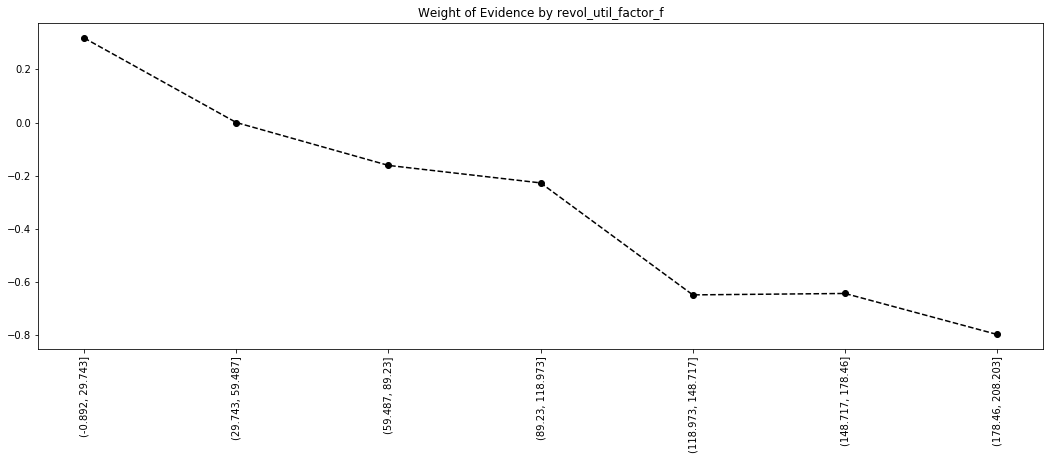

In [53]:
plot_by_woe(df_temp, 90)

In [54]:
df_inputs_prepr['revol_util_factor:1'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(12))),1,0)
df_inputs_prepr['revol_util_factor:2'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(12,24))),1,0)
df_inputs_prepr['revol_util_factor:3'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(24,36))),1,0)
df_inputs_prepr['revol_util_factor:4'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(36,48))),1,0)
df_inputs_prepr['revol_util_factor:5'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(48,60))),1,0)
df_inputs_prepr['revol_util_factor:6'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(60,72))),1,0)
df_inputs_prepr['revol_util_factor:7'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(72,84))),1,0)
df_inputs_prepr['revol_util_factor:8'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(84,96))),1,0)
df_inputs_prepr['revol_util_factor:9'] = np.where((df_inputs_prepr['revol_util_factor_f'].isin(range(96,int(df_inputs_prepr['revol_util_factor'].max())))),1,0)

In [55]:
df_inputs_prepr = df_inputs_prepr.drop(['revol_util_factor','revol_util_factor_f'], axis=1)

In [56]:
df_inputs_prepr.head(2)
# will need to make sure I am dropping columns as I do the appends

,open_acc,tot_cur_bal,tot_coll_amt,zip_code_t,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,...,int_rate_factor:11,revol_util_factor:1,revol_util_factor:2,revol_util_factor:3,revol_util_factor:4,revol_util_factor:5,revol_util_factor:6,revol_util_factor:7,revol_util_factor:8,revol_util_factor:9
1481818,8.0,2221.0,327.0,112,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
2287801,8.0,187118.0,0.0,836,0,1,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


In [57]:
df_inputs_prepr['open_acc_t'] = pd.cut(df_inputs_prepr['open_acc'],30)
df_temp = woe_ordered_continuous(df_inputs_prepr,'open_acc_t',df_targets_prepr)
df_temp

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1823: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc_t,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.101, 3.367]",34014,0.890427,1.959470e-02,30287.0,3727.0,2.006914e-02,0.016437,0.199650,NaN,NaN,inf
1,"(3.367, 6.733]",243650,0.881867,1.403612e-01,214867.0,28783.0,1.423778e-01,0.126940,0.114770,0.008560,0.084881,inf
2,"(6.733, 10.1]",569005,0.871212,3.277909e-01,495724.0,73281.0,3.284826e-01,0.323187,0.016253,0.010655,0.098516,inf
3,"(10.1, 13.467]",360514,0.864144,2.076840e-01,311536.0,48978.0,2.064338e-01,0.216005,-0.045321,0.007068,0.061574,inf
4,"(13.467, 16.833]",233434,0.864399,1.344760e-01,201780.0,31654.0,1.337059e-01,0.139602,-0.043151,0.000255,0.002170,inf
5,"(16.833, 20.2]",166141,0.864934,9.571007e-02,143701.0,22440.0,9.522090e-02,0.098966,-0.038575,0.000535,0.004576,inf
6,"(20.2, 23.567]",60920,0.861819,3.509463e-02,52502.0,8418.0,3.478951e-02,0.037125,-0.064986,0.003115,0.026411,inf
7,"(23.567, 26.933]",32451,0.860158,1.869429e-02,27913.0,4538.0,1.849605e-02,0.020014,-0.078858,0.001660,0.013873,inf
8,"(26.933, 30.3]",20375,0.862037,1.173758e-02,17564.0,2811.0,1.163847e-02,0.012397,-0.063153,0.001878,0.015705,inf
9,"(30.3, 33.667]",7097,0.866422,4.088421e-03,6149.0,948.0,4.074525e-03,0.004181,-0.025774,0.004386,0.037379,inf


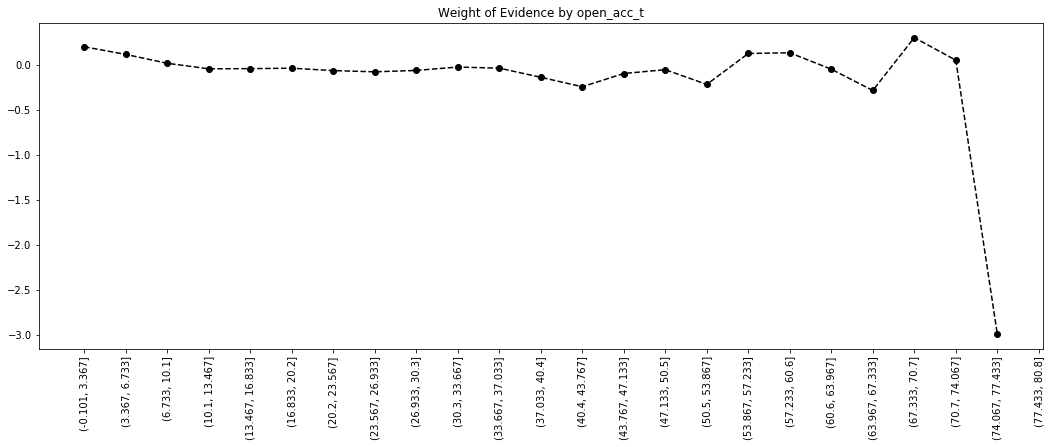

In [58]:
plot_by_woe(df_temp, 90)

In [59]:
df_inputs_prepr['open_acc:1'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(3))),1,0)
df_inputs_prepr['open_acc:2'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(3,6))),1,0)
df_inputs_prepr['open_acc:3'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(6,10))),1,0)
df_inputs_prepr['open_acc:4'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(10,15))),1,0)
df_inputs_prepr['open_acc:5'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(15,20))),1,0)
df_inputs_prepr['open_acc:6'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(20,30))),1,0)
df_inputs_prepr['open_acc:9'] = np.where((df_inputs_prepr['open_acc_t'].isin(range(30,int(df_inputs_prepr['open_acc'].max())))),1,0)

In [60]:
df_inputs_prepr = df_inputs_prepr.drop(['open_acc','open_acc_t'], axis=1)

In [61]:
df_inputs_prepr['zip_code_f'] = pd.cut(df_inputs_prepr['zip_code_t'],5)
df_temp = woe_ordered_continuous(df_inputs_prepr,'zip_code_f',df_targets_prepr)
df_temp

,zip_code_f,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.999, 199.8]",358539,0.866650,0.206546,310728.0,47811.0,0.205898,0.210858,-0.023802,NaN,NaN,0.000525
1,"(199.8, 399.6]",412044,0.866988,0.237369,357237.0,54807.0,0.236717,0.241712,-0.020883,0.000337,0.002919,0.000525
2,"(399.6, 599.4]",214028,0.870265,0.123297,186261.0,27767.0,0.123423,0.122459,0.007836,0.003277,0.028719,0.000525
3,"(599.4, 799.2]",310565,0.869638,0.178909,270079.0,40486.0,0.178963,0.178553,0.002294,0.000627,0.005542,0.000525
4,"(799.2, 999.0]",440702,0.873216,0.253878,384828.0,55874.0,0.254999,0.246418,0.034233,0.003578,0.031939,0.000525


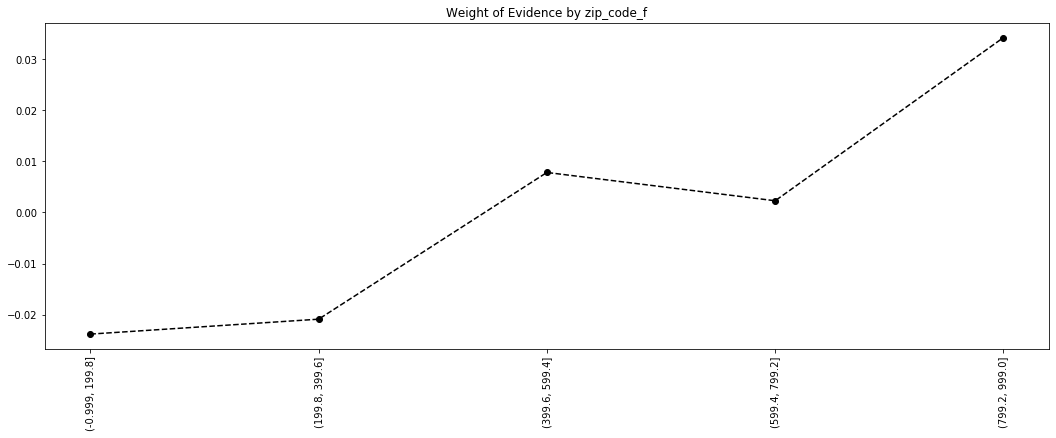

In [62]:
plot_by_woe(df_temp, 90)

In [63]:
df_inputs_prepr['zip_code:1'] = np.where((df_inputs_prepr['zip_code_f'].isin(range(200))),1,0)
df_inputs_prepr['zip_code:2'] = np.where((df_inputs_prepr['zip_code_f'].isin(range(200,400))),1,0)
df_inputs_prepr['zip_code:3'] = np.where((df_inputs_prepr['zip_code_f'].isin(range(400,600))),1,0)
df_inputs_prepr['zip_code:4'] = np.where((df_inputs_prepr['zip_code_f'].isin(range(600,800))),1,0)
df_inputs_prepr['zip_code:5'] = np.where((df_inputs_prepr['zip_code_f'].isin(range(800,int(df_inputs_prepr['zip_code_t'].max())))),1,0)

In [64]:
df_inputs_prepr = df_inputs_prepr.drop(['zip_code_t','zip_code_f'], axis=1)

In [65]:
df_inputs_prepr.head(2)

,tot_cur_bal,tot_coll_amt,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,...,open_acc:3,open_acc:4,open_acc:5,open_acc:6,open_acc:9,zip_code:1,zip_code:2,zip_code:3,zip_code:4,zip_code:5
1481818,2221.0,327.0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
2287801,187118.0,0.0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1


In [66]:
df_inputs_prepr['tot_cur_bal_t'] = pd.cut(df_inputs_prepr['tot_cur_bal'],300)
df_temp = woe_ordered_continuous(df_inputs_prepr,'tot_cur_bal_t',df_targets_prepr)
df_temp

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1823: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,tot_cur_bal_t,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9971.659, 33238.863]",492966,0.856317,2.839865e-01,422135.0,70831.0,2.797202e-01,0.312382,-0.110436,NaN,NaN,inf
1,"(33238.863, 66477.727]",308881,0.847741,1.779393e-01,261851.0,47030.0,1.735109e-01,0.207414,-0.178475,0.008576,0.068038,inf
2,"(66477.727, 99716.59]",141708,0.856211,8.163477e-02,121332.0,20376.0,8.039848e-02,0.089863,-0.111292,0.008471,0.067183,inf
3,"(99716.59, 132955.453]",107701,0.868367,6.204411e-02,93524.0,14177.0,6.197201e-02,0.062524,-0.008867,0.012156,0.102424,inf
4,"(132955.453, 166194.317]",105882,0.874086,6.099622e-02,92550.0,13332.0,6.132660e-02,0.058797,0.042117,0.005719,0.050985,inf
5,"(166194.317, 199433.18]",101419,0.877696,5.842519e-02,89015.0,12404.0,5.898420e-02,0.054705,0.075321,0.003609,0.033204,inf
6,"(199433.18, 232672.043]",88815,0.885492,5.116431e-02,78645.0,10170.0,5.211270e-02,0.044852,0.150037,0.007797,0.074716,inf
7,"(232672.043, 265910.907]",76305,0.891383,4.395758e-02,68017.0,8288.0,4.507025e-02,0.036552,0.209484,0.005891,0.059447,inf
8,"(265910.907, 299149.77]",63912,0.894370,3.681826e-02,57161.0,6751.0,3.787671e-02,0.029774,0.240717,0.002987,0.031232,inf
9,"(299149.77, 332388.633]",51782,0.895968,2.983044e-02,46395.0,5387.0,3.074282e-02,0.023758,0.257738,0.001597,0.017022,inf


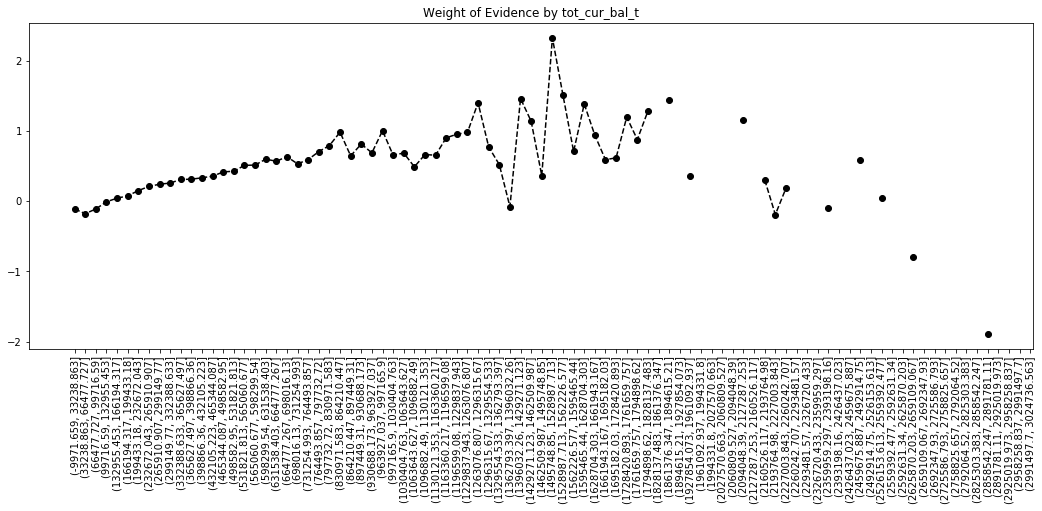

In [67]:
plot_by_woe(df_temp, 90)

In [68]:
df_inputs_prepr['tot_cur_bal:1'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(30000))),1,0)
df_inputs_prepr['tot_cur_bal:2'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(30000,70000))),1,0)
df_inputs_prepr['tot_cur_bal:3'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(70000,120000))),1,0)
df_inputs_prepr['tot_cur_bal:4'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(120000,180000))),1,0)
df_inputs_prepr['tot_cur_bal:5'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(180000,250000))),1,0)
df_inputs_prepr['tot_cur_bal:6'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(250000,350000))),1,0)
df_inputs_prepr['tot_cur_bal:7'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(350000,500000))),1,0)
df_inputs_prepr['tot_cur_bal:8'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(500000,750000))),1,0)
df_inputs_prepr['tot_cur_bal:9'] = np.where((df_inputs_prepr['tot_cur_bal_t'].isin(range(750000,int(df_inputs_prepr['tot_cur_bal'].max())))),1,0)

In [69]:
df_inputs_prepr = df_inputs_prepr.drop(['tot_cur_bal','tot_cur_bal_t'], axis=1)

In [70]:
df_inputs_prepr.head(2)

,tot_coll_amt,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,...,zip_code:5,tot_cur_bal:1,tot_cur_bal:2,tot_cur_bal:3,tot_cur_bal:4,tot_cur_bal:5,tot_cur_bal:6,tot_cur_bal:7,tot_cur_bal:8,tot_cur_bal:9
1481818,327.0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2287801,0.0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0


In [71]:
df_inputs_prepr = df_inputs_prepr.drop(['tot_coll_amt'], axis=1)

In [72]:
loan_data_target_train.head(1)

1481818    1
Name: good_bad, dtype: int64

In [73]:
df_inputs_prepr.shape

(1735878, 96)

### Apply same breakdown for test data
Since I did train test split already, need to make sure applying the same methodology to test data

In [74]:
df_inputs_prepr_t, df_targets_prepr_t = loan_data_input_test, loan_data_target_test

In [75]:
df_inputs_prepr_t['loan_amnt_factor'] = pd.cut(df_inputs_prepr_t['loan_amnt'],30)

In [76]:
df_inputs_prepr_t['loan_amnt_factor:1'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(1817))),1,0)
df_inputs_prepr_t['loan_amnt_factor:2'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(1817,7084))),1,0)
df_inputs_prepr_t['loan_amnt_factor:3'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(7084,11034))),1,0)
df_inputs_prepr_t['loan_amnt_factor:4'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(11034,28150))),1,0)
df_inputs_prepr_t['loan_amnt_factor:5'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(28150,28160))),1,0)
df_inputs_prepr_t['loan_amnt_factor:6'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(28160,32100))),1,0)
df_inputs_prepr_t['loan_amnt_factor:7'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(32100,36050))),1,0)
df_inputs_prepr_t['loan_amnt_factor:8'] = np.where((df_inputs_prepr_t['loan_amnt_factor'].isin(range(36050,int(df_inputs_prepr_t['loan_amnt'].max())))),1,0)

In [77]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['loan_amnt', 'loan_amnt_factor'], axis=1)

In [78]:
df_inputs_prepr_t['annual_inc_factor'] = pd.cut(df_inputs_prepr_t['annual_inc'],100)

In [79]:
df_inputs_prepr_t['annual_inc_factor:1'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(7000))),1,0)
df_inputs_prepr_t['annual_inc_factor:2'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(7000,42000))),1,0)
df_inputs_prepr_t['annual_inc_factor:3'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(42000,70000))),1,0)
df_inputs_prepr_t['annual_inc_factor:4'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(70000,100000))),1,0)
df_inputs_prepr_t['annual_inc_factor:5'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(100000,112000))),1,0)
df_inputs_prepr_t['annual_inc_factor:6'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(112000,126000))),1,0)
df_inputs_prepr_t['annual_inc_factor:7'] = np.where((df_inputs_prepr_t['annual_inc_factor'].isin(range(126000,int(df_inputs_prepr_t['annual_inc'].max())))),1,0)

In [80]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['annual_inc','annual_inc_factor'], axis=1)

In [81]:
df_inputs_prepr_t['int_rate_factor_f'] = pd.cut(df_inputs_prepr_t['int_rate_factor'],10)

In [82]:
df_inputs_prepr_t['int_rate_factor:1'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(8))),1,0)
df_inputs_prepr_t['int_rate_factor:2'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(8,11))),1,0)
df_inputs_prepr_t['int_rate_factor:3'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(11,13))),1,0)
df_inputs_prepr_t['int_rate_factor:4'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(13,15))),1,0)
df_inputs_prepr_t['int_rate_factor:5'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(15,17))),1,0)
df_inputs_prepr_t['int_rate_factor:6'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(17,19))),1,0)
df_inputs_prepr_t['int_rate_factor:7'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(19,21))),1,0)
df_inputs_prepr_t['int_rate_factor:8'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(21,23))),1,0)
df_inputs_prepr_t['int_rate_factor:9'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(23,25))),1,0)
df_inputs_prepr_t['int_rate_factor:10'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(25,27))),1,0)
df_inputs_prepr_t['int_rate_factor:11'] = np.where((df_inputs_prepr_t['int_rate_factor_f'].isin(range(27,int(df_inputs_prepr_t['int_rate_factor'].max())))),1,0)

In [83]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['int_rate_factor','int_rate_factor_f'], axis=1)

In [84]:
df_inputs_prepr_t['revol_util_factor_f'] = pd.cut(df_inputs_prepr_t['revol_util_factor'],30)

In [85]:
df_inputs_prepr_t['revol_util_factor:1'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(12))),1,0)
df_inputs_prepr_t['revol_util_factor:2'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(12,24))),1,0)
df_inputs_prepr_t['revol_util_factor:3'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(24,36))),1,0)
df_inputs_prepr_t['revol_util_factor:4'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(36,48))),1,0)
df_inputs_prepr_t['revol_util_factor:5'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(48,60))),1,0)
df_inputs_prepr_t['revol_util_factor:6'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(60,72))),1,0)
df_inputs_prepr_t['revol_util_factor:7'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(72,84))),1,0)
df_inputs_prepr_t['revol_util_factor:8'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(84,96))),1,0)
df_inputs_prepr_t['revol_util_factor:9'] = np.where((df_inputs_prepr_t['revol_util_factor_f'].isin(range(96,int(df_inputs_prepr_t['revol_util_factor'].max())))),1,0)

In [86]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['revol_util_factor','revol_util_factor_f'], axis=1)

In [87]:
df_inputs_prepr_t['open_acc_t'] = pd.cut(df_inputs_prepr_t['open_acc'],30)

In [88]:
df_inputs_prepr_t['open_acc:1'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(3))),1,0)
df_inputs_prepr_t['open_acc:2'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(3,6))),1,0)
df_inputs_prepr_t['open_acc:3'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(6,10))),1,0)
df_inputs_prepr_t['open_acc:4'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(10,15))),1,0)
df_inputs_prepr_t['open_acc:5'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(15,20))),1,0)
df_inputs_prepr_t['open_acc:6'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(20,30))),1,0)
df_inputs_prepr_t['open_acc:9'] = np.where((df_inputs_prepr_t['open_acc_t'].isin(range(30,int(df_inputs_prepr_t['open_acc'].max())))),1,0)

In [89]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['open_acc','open_acc_t'], axis=1)

In [90]:
df_inputs_prepr_t['zip_code_f'] = pd.cut(df_inputs_prepr_t['zip_code_t'],5)

In [91]:
df_inputs_prepr_t['zip_code:1'] = np.where((df_inputs_prepr_t['zip_code_f'].isin(range(200))),1,0)
df_inputs_prepr_t['zip_code:2'] = np.where((df_inputs_prepr_t['zip_code_f'].isin(range(200,400))),1,0)
df_inputs_prepr_t['zip_code:3'] = np.where((df_inputs_prepr_t['zip_code_f'].isin(range(400,600))),1,0)
df_inputs_prepr_t['zip_code:4'] = np.where((df_inputs_prepr_t['zip_code_f'].isin(range(600,800))),1,0)
df_inputs_prepr_t['zip_code:5'] = np.where((df_inputs_prepr_t['zip_code_f'].isin(range(800,int(df_inputs_prepr_t['zip_code_t'].max())))),1,0)

In [92]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['zip_code_t','zip_code_f'], axis=1)

In [93]:
df_inputs_prepr_t['tot_cur_bal_t'] = pd.cut(df_inputs_prepr_t['tot_cur_bal'],300)

In [94]:
df_inputs_prepr_t['tot_cur_bal:1'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(30000))),1,0)
df_inputs_prepr_t['tot_cur_bal:2'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(30000,70000))),1,0)
df_inputs_prepr_t['tot_cur_bal:3'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(70000,120000))),1,0)
df_inputs_prepr_t['tot_cur_bal:4'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(120000,180000))),1,0)
df_inputs_prepr_t['tot_cur_bal:5'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(180000,250000))),1,0)
df_inputs_prepr_t['tot_cur_bal:6'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(250000,350000))),1,0)
df_inputs_prepr_t['tot_cur_bal:7'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(350000,500000))),1,0)
df_inputs_prepr_t['tot_cur_bal:8'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(500000,750000))),1,0)
df_inputs_prepr_t['tot_cur_bal:9'] = np.where((df_inputs_prepr_t['tot_cur_bal_t'].isin(range(750000,int(df_inputs_prepr_t['tot_cur_bal'].max())))),1,0)

In [95]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['tot_cur_bal','tot_cur_bal_t'], axis=1)

In [96]:
df_inputs_prepr_t = df_inputs_prepr_t.drop(['tot_coll_amt'], axis=1)

In [97]:
df_inputs_prepr_t.head(2)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,...,zip_code:5,tot_cur_bal:1,tot_cur_bal:2,tot_cur_bal:3,tot_cur_bal:4,tot_cur_bal:5,tot_cur_bal:6,tot_cur_bal:7,tot_cur_bal:8,tot_cur_bal:9
1810368,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
1238852,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [98]:
loan_data_input_train = df_inputs_prepr
loan_data_input_test = df_inputs_prepr_t

In [100]:
# loan_data_input_train = loan_data_input_train.drop(['tot_coll_amt_t'], axis=1)

## Logistic Regression Modeling

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [102]:
from sklearn import linear_model
import scipy.stats as stat

In [103]:
loan_data_target_train = pd.DataFrame(loan_data_target_train)
loan_data_target_train_2 = pd.DataFrame(loan_data_target_train_2)

In [104]:
loan_data_target_test = pd.DataFrame(loan_data_target_test)
loan_data_target_test_2 = pd.DataFrame(loan_data_target_test_2)

In [105]:
print("input train shape: {} \ntargets train shape: {}".format(loan_data_input_train.shape, loan_data_target_train.shape))

input train shape: (1735878, 96) 
targets train shape: (1735878,)


In [106]:
print("inputs test shape: {} \ntargets test shape: {}".format(loan_data_input_test.shape, loan_data_target_test.shape))

inputs test shape: (578627, 96) 
targets test shape: (578627,)


In [107]:
print("input train w no woe cont shape: {} \ntargets train w no woe cont shape: {}".format(loan_data_input_train_2.shape, loan_data_target_train_2.shape))

input train w no woe cont shape: (1735878, 48) 
targets train w no woe cont shape: (1735878, 1)


In [108]:
print("inputs test w no woe cont shape: {} \ntargets test w no woe cont shape: {}".format(loan_data_input_test_2.shape, loan_data_target_test_2.shape))

inputs test w no woe cont shape: (578627, 48) 
targets test w no woe cont shape: (578627, 1)


In [109]:
loan_data_input_train.head(2)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,...,zip_code:5,tot_cur_bal:1,tot_cur_bal:2,tot_cur_bal:3,tot_cur_bal:4,tot_cur_bal:5,tot_cur_bal:6,tot_cur_bal:7,tot_cur_bal:8,tot_cur_bal:9
1481818,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2287801,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,1,1,0,0,0,0


In [110]:
loan_data_input_test.head(2)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,...,zip_code:5,tot_cur_bal:1,tot_cur_bal:2,tot_cur_bal:3,tot_cur_bal:4,tot_cur_bal:5,tot_cur_bal:6,tot_cur_bal:7,tot_cur_bal:8,tot_cur_bal:9
1810368,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,0,0
1238852,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [111]:
loan_data_input_train_2.head(2)

,loan_amnt,annual_inc,open_acc,tot_cur_bal,tot_coll_amt,int_rate_factor,revol_util_factor,zip_code_t,grade:A,grade:B,...,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
1481818,6000.0,56000.0,8.0,2221.0,327.0,11.49,19.3,112,0,1,...,0,0,0,0,0,0,0,0,1,0
2287801,11000.0,50717.0,8.0,187118.0,0.0,12.40,32.6,836,0,1,...,0,0,0,0,0,0,0,0,0,1


In [112]:
loan_data_input_test_2.head(2)

,loan_amnt,annual_inc,open_acc,tot_cur_bal,tot_coll_amt,int_rate_factor,revol_util_factor,zip_code_t,grade:A,grade:B,...,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
1810368,2300.0,58000.0,14.0,348525.0,0.0,10.56,34.6,956,0,1,...,0,0,0,0,0,0,0,1,1,0
1238852,18000.0,67000.0,22.0,64704.0,0.0,15.99,43.7,981,0,0,...,0,1,0,0,0,0,0,0,1,0


### Drop k-1 from One Hot Encoding

In [113]:
ref_categories = ['grade:G','home_ownership:RENT','purpose:wedding','emp_length_int:10.0','revol_util_factor:9','int_rate_factor:11','annual_inc_factor:7','loan_amnt_factor:8','term_int:60.0']

In [114]:
ref_categories_2 = ['grade:G','home_ownership:RENT','purpose:wedding','emp_length_int:10.0','term_int:60.0']

In [115]:
input_train = loan_data_input_train

In [116]:
input_train_2 = loan_data_input_train_2

In [117]:
input_train = input_train.drop(ref_categories, axis=1)

In [118]:
input_train_2 = input_train_2.drop(ref_categories_2, axis=1)

In [119]:
reg = LogisticRegression(class_weight={0:3, 1:1})

In [120]:
reg.fit(input_train, loan_data_target_train)

LogisticRegression(C=1.0, class_weight={0: 3, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [121]:
def log_reg_summary_table(train_df,reg=reg):
    feature_name = train_df.columns.values
    summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
    summary_table['Coefficients'] = np.transpose(reg.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
    summary_table = summary_table.sort_index()
    return summary_table

In [122]:
feature_name = input_train.columns.values
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-0.356493
1,grade:A,3.819231
2,grade:B,3.184835
3,grade:C,2.569750
4,grade:D,1.873319
5,grade:E,1.013369
6,grade:F,0.317110
7,home_ownership:ANY,1.213537
8,home_ownership:MORTGAGE,0.174759
9,home_ownership:NONE,0.204957


In [123]:
print("Linear Regression training model score: {:.3%}".format(reg.score(input_train,loan_data_target_train)))

Linear Regression training model score: 83.831%


### Apply model to test data set

In [124]:
input_test = loan_data_input_test

In [125]:
input_test_2 = loan_data_input_test_2

In [126]:
input_test = input_test.drop(ref_categories, axis=1)

In [127]:
input_test_2 = input_test_2.drop(ref_categories_2, axis=1)

In [128]:
yhat_test = reg.predict(input_test)

In [129]:
yhat_test_proba = reg.predict_proba(input_test)

In [130]:
yhat_test_proba = yhat_test_proba[: ][: ,1]

In [131]:
loan_data_targets_test_temp = loan_data_target_test

In [132]:
loan_data_targets_test_temp.shape

(578627,)

In [133]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)

In [134]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(yhat_test_proba)], axis=1)

In [135]:
df_actual_predicted_probs.columns = ['loan_data_targets_test','yhat_test_proba']

In [136]:
df_actual_predicted_probs.index = loan_data_input_test.index

In [137]:
df_actual_predicted_probs.head()

,loan_data_targets_test,yhat_test_proba
1810368,1,0.873317
1238852,1,0.582308
1666975,1,0.761899
240250,1,0.892963
521786,1,0.449755


### Apply ROC Curve
Also take a look at confusion matrix

In [138]:
tr = 0.5
df_actual_predicted_probs['yhat_test'] = np.where(df_actual_predicted_probs['yhat_test_proba'] > tr, 1, 0)

In [139]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,27260,48494
1,71290,431583


In [140]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.047112,0.083809
1,0.123205,0.745874


In [141]:
from sklearn.metrics import confusion_matrix, classification_report

In [142]:
print(confusion_matrix(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test']))

[[ 27260  48494]
 [ 71290 431583]]


In [143]:
print(classification_report(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test']))

             precision    recall  f1-score   support

          0       0.28      0.36      0.31     75754
          1       0.90      0.86      0.88    502873

avg / total       0.82      0.79      0.80    578627



In [144]:
from sklearn.metrics import roc_curve, roc_auc_score

In [145]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

(array([0.       , 0.       , 0.       , ..., 0.9999472, 1.       ,
        1.       ]),
 array([1.98857366e-06, 9.94286828e-06, 1.39200156e-05, ...,
        9.99998011e-01, 9.99998011e-01, 1.00000000e+00]),
 array([0.975893  , 0.97416313, 0.97361623, ..., 0.12797125, 0.11477958,
        0.09995227]))

In [146]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

TypeError: 'str' object is not callable

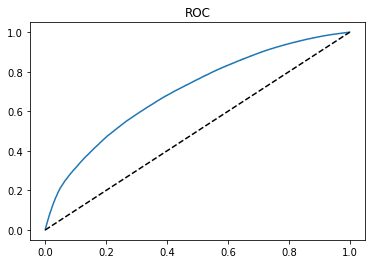

In [147]:
plt.plot(fpr,tpr)
plt.plot(fpr,fpr, linestyle='--', color='k')
plt.title('ROC')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [148]:
auroc = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['yhat_test_proba'])

In [149]:
print("The Area Under the Curve for the ROC is: {:3f}".format(auroc))

The Area Under the Curve for the ROC is: 0.700693


### Random Forest Classifier

In [1]:
from sklearn.ensemble import RandomForestClassifier

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [158]:
loan_data_target_test.shape

(578627,)

In [160]:
loan_data_target_test_2.shape

(578627, 1)

In [161]:
y_glb = loan_data_target_train_2.iloc[:,0]
# convert dataframe to a series

In [162]:
y_glb_2 = loan_data_target_train_2.iloc[:,0]

In [163]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1).fit(input_train, y_glb)

In [164]:
rf2 = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1).fit(input_train_2, y_glb_2)

In [165]:
print("The random forest classifier score is is: {:3%}".format(rf.score(input_train, y_glb)))

The random forest classifier score is is: 94.546679%


In [166]:
print("The random forest classifier w no woe cont score is: {:3%}".format(rf2.score(input_train_2, y_glb_2)))

The random forest classifier w no woe cont score is: 99.997696%


In [167]:
yhat_test_rf = rf.predict_proba(input_test)

In [168]:
yhat_test_rf_2 = rf2.predict_proba(input_test_2)

In [169]:
yhat_test_rf = pd.DataFrame(yhat_test_rf)

In [170]:
yhat_test_rf_2 = pd.DataFrame(yhat_test_rf_2)

In [171]:
df_actual_predicted_probs_rf = pd.concat([loan_data_target_test, yhat_test_rf.iloc[:,1]], axis=1)
df_actual_predicted_probs_rf.columns = ['loan_data_targets_test','yhat_test_rf']
df_actual_predicted_probs_rf.index = loan_data_input_test.index
df_actual_predicted_probs_rf.head(3)

,loan_data_targets_test,yhat_test_rf
1810368,1,0.91000
1238852,1,0.89250
1666975,1,0.93346


In [194]:
df_actual_predicted_probs_rf_2 = pd.concat([loan_data_target_test_2, yhat_test_rf_2.iloc[:,1]], axis=1)
df_actual_predicted_probs_rf_2.columns = ['loan_data_targets_test_2','yhat_test_rf_2']
#df_actual_predicted_probs_rf_2.index = loan_data_input_test_2.index
df_actual_predicted_probs_rf_2.head(3)

,loan_data_targets_test_2,yhat_test_rf_2
0,NaN,0.91
1,NaN,0.84
2,NaN,0.96


In [193]:
df_actual_predicted_probs_rf_2.head(2)

,loan_data_targets_test_2,yhat_test_rf_2
0,NaN,0.91
1,NaN,0.84


In [173]:
loan_data_input_test_2.head(2)

,loan_amnt,annual_inc,open_acc,tot_cur_bal,tot_coll_amt,int_rate_factor,revol_util_factor,zip_code_t,grade:A,grade:B,...,emp_length_int:3.0,emp_length_int:4.0,emp_length_int:5.0,emp_length_int:6.0,emp_length_int:7.0,emp_length_int:8.0,emp_length_int:9.0,emp_length_int:10.0,term_int:36.0,term_int:60.0
1810368,2300.0,58000.0,14.0,348525.0,0.0,10.56,34.6,956,0,1,...,0,0,0,0,0,0,0,1,1,0
1238852,18000.0,67000.0,22.0,64704.0,0.0,15.99,43.7,981,0,0,...,0,1,0,0,0,0,0,0,1,0


In [174]:
tr = 0.7
df_actual_predicted_probs_rf['yhat_test_proba_rf'] = np.where(df_actual_predicted_probs_rf['yhat_test_rf'] > tr, 1, 0)

In [195]:
tr = 0.5
df_actual_predicted_probs_rf_2['yhat_test_proba_rf_2'] = np.where(df_actual_predicted_probs_rf_2['yhat_test_rf_2'] > tr, 1, 0)

In [176]:
pd.crosstab(df_actual_predicted_probs_rf['loan_data_targets_test'], df_actual_predicted_probs_rf['yhat_test_proba_rf'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,15878,59876
1,39081,463792


In [196]:
pd.crosstab(df_actual_predicted_probs_rf_2['loan_data_targets_test_2'], df_actual_predicted_probs_rf_2['yhat_test_proba_rf_2'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0.0,54082,21672
1.0,398338,104535


In [178]:
print(confusion_matrix(df_actual_predicted_probs_rf['loan_data_targets_test'], df_actual_predicted_probs_rf['yhat_test_proba_rf']))

[[ 15878  59876]
 [ 39081 463792]]


In [179]:
print(classification_report(df_actual_predicted_probs_rf['loan_data_targets_test'], df_actual_predicted_probs_rf['yhat_test_proba_rf']))

             precision    recall  f1-score   support

          0       0.29      0.21      0.24     75754
          1       0.89      0.92      0.90    502873

avg / total       0.81      0.83      0.82    578627



In [180]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(df_actual_predicted_probs_rf['loan_data_targets_test'], df_actual_predicted_probs_rf['yhat_test_rf'])

TypeError: 'str' object is not callable

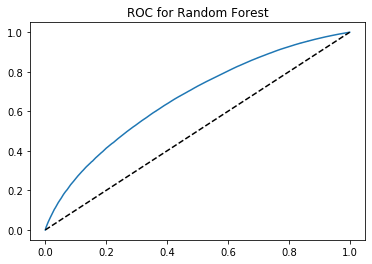

In [181]:
plt.plot(fpr_rf,tpr_rf)
plt.plot(fpr_rf,fpr_rf, linestyle='--', color='k')
plt.title('ROC for Random Forest')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [182]:
auroc_rf = roc_auc_score(df_actual_predicted_probs_rf['loan_data_targets_test'], df_actual_predicted_probs_rf['yhat_test_rf'])
print("The Area Under the Curve for the ROC is: {:3f}".format(auroc_rf))

The Area Under the Curve for the ROC is: 0.667351


In [183]:
rf_imb = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight={0:10, 1:1}, random_state=42, n_jobs=-1).fit(input_train, y_glb)

In [184]:
print("The random forest classifier with class weighting of 10 to 1 for bad to good score is: {:3%}".format(rf_imb.score(input_train, y_glb)))

The random forest classifier with class weighting of 10 to 1 for bad to good score is: 89.415500%


In [185]:
yhat_test_rf_imb = rf_imb.predict_proba(input_test)
yhat_test_rf_imb = pd.DataFrame(yhat_test_rf_imb)

In [186]:
df_actual_predicted_probs_rf_imb = pd.concat([loan_data_target_test, yhat_test_rf_imb.iloc[:,1]], axis=1)
df_actual_predicted_probs_rf_imb.columns = ['loan_data_targets_test','yhat_test_rf_imb']
df_actual_predicted_probs_rf_imb.index = loan_data_input_test.index
df_actual_predicted_probs_rf_imb.head(3)

,loan_data_targets_test,yhat_test_rf_imb
1810368,1,0.960000
1238852,1,0.905793
1666975,1,0.941288


In [187]:
tr = 0.7
df_actual_predicted_probs_rf_imb['yhat_test_proba_rf_imb'] = np.where(df_actual_predicted_probs_rf_imb['yhat_test_rf_imb'] > tr, 1, 0)

In [188]:
print(confusion_matrix(df_actual_predicted_probs_rf_imb['loan_data_targets_test'], df_actual_predicted_probs_rf_imb['yhat_test_proba_rf_imb']))
print(classification_report(df_actual_predicted_probs_rf_imb['loan_data_targets_test'], df_actual_predicted_probs_rf_imb['yhat_test_proba_rf_imb']))

[[ 18340  57414]
 [ 60261 442612]]
             precision    recall  f1-score   support

          0       0.23      0.24      0.24     75754
          1       0.89      0.88      0.88    502873

avg / total       0.80      0.80      0.80    578627



In [189]:
fpr_rf_imb, tpr_rf_imb, thresholds_rf_imb = roc_curve(df_actual_predicted_probs_rf_imb['loan_data_targets_test'], df_actual_predicted_probs_rf_imb['yhat_test_rf_imb'])

TypeError: 'str' object is not callable

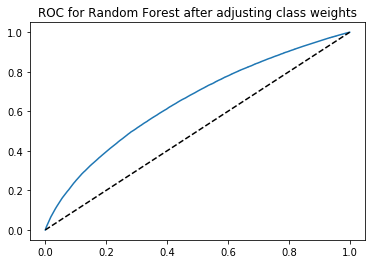

In [190]:
plt.plot(fpr_rf_imb,tpr_rf_imb)
plt.plot(fpr_rf_imb,fpr_rf_imb, linestyle='--', color='k')
plt.title('ROC for Random Forest after adjusting class weights')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [197]:
auroc_rf_imb = roc_auc_score(df_actual_predicted_probs_rf_imb['loan_data_targets_test'], df_actual_predicted_probs_rf_imb['yhat_test_rf_imb'])
print("The Area Under the Curve for the ROC is: {:3f}".format(auroc_rf_imb))

The Area Under the Curve for the ROC is: 0.648509


In [198]:
from sklearn.ensemble import GradientBoostingClassifier

In [199]:
gbl = GradientBoostingClassifier(loss='deviance', learning_rate=0.001, n_estimators=300, subsample=1, min_samples_leaf=1, max_depth=2, random_state=42).fit(input_train, y_glb)
# takes about 15-20 min to run w n_est at 300, learning rate at 0.001, and max_depth at 2

In [200]:
print("Accuracy on Gradient Boost training model: {:.3%}".format(gbl.score(input_train, y_glb)))

Accuracy on Gradient Boost training model: 86.938%


In [201]:
yhat_test_gbl = gbl.predict_proba(input_test)
yhat_test_gbl = pd.DataFrame(yhat_test_gbl)

In [202]:
df_actual_predicted_probs_gbl = pd.concat([loan_data_target_test, yhat_test_gbl.iloc[:,1]], axis=1)
df_actual_predicted_probs_gbl.columns = ['loan_data_targets_test','yhat_test_gbl']
df_actual_predicted_probs_gbl.index = loan_data_input_test.index
df_actual_predicted_probs_gbl.head(3)

,loan_data_targets_test,yhat_test_gbl
1810368,1,0.878424
1238852,1,0.855330
1666975,1,0.891221


In [203]:
tr = 0.5
df_actual_predicted_probs_gbl['yhat_test_proba_gbl'] = np.where(df_actual_predicted_probs_gbl['yhat_test_gbl'] > tr, 1, 0)

In [204]:
print(confusion_matrix(df_actual_predicted_probs_gbl['loan_data_targets_test'], df_actual_predicted_probs_gbl['yhat_test_proba_gbl']))
print(classification_report(df_actual_predicted_probs_gbl['loan_data_targets_test'], df_actual_predicted_probs_gbl['yhat_test_proba_gbl']))

[[     0  75754]
 [     0 502873]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     75754
          1       0.87      1.00      0.93    502873

avg / total       0.76      0.87      0.81    578627



/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
fpr_gbl, tpr_gbl, thresholds_gbl = roc_curve(df_actual_predicted_probs_gbl['loan_data_targets_test'], df_actual_predicted_probs_gbl['yhat_test_gbl'])

TypeError: 'str' object is not callable

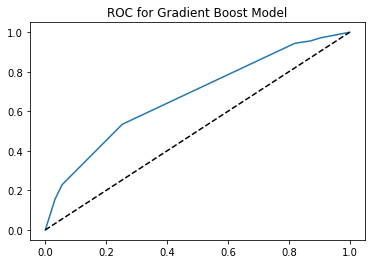

In [206]:
plt.plot(fpr_gbl,tpr_gbl)
plt.plot(fpr_gbl,fpr_gbl, linestyle='--', color='k')
plt.title('ROC for Gradient Boost Model')
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate');

In [207]:
auroc_gbl = roc_auc_score(df_actual_predicted_probs_gbl['loan_data_targets_test'], df_actual_predicted_probs_gbl['yhat_test_gbl'])
print("The Area Under the Curve for the Gradient Boost Model is: {:3f}".format(auroc_gbl))

The Area Under the Curve for the Gradient Boost Model is: 0.676524


# New Code

#### I can add in code for Gini Coefficient here later

### Convert PD Model to Scorecard

In [212]:
df_ref_cat = pd.DataFrame(ref_categories, columns=['Feature Name'])

In [214]:
df_ref_cat['Coef'] = 0

In [215]:
df_ref_cat['p-value'] = np.nan

In [216]:
df_scorecard = pd.concat([summary_table, df_ref_cat])
df_scorecard = df_scorecard.reset_index()
df_scorecard['Orig_feat_name'] = df_scorecard['Feature Name'].str.split(':').str[0]

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [217]:
df_scorecard.head(2)

,index,Coef,Coefficients,Feature Name,Feature name,p-value,Orig_feat_name
0,0,NaN,-0.356493,NaN,Intercept,NaN,NaN
1,1,NaN,3.819231,NaN,grade:A,NaN,NaN


In [220]:
min_sum_coef = df_scorecard.groupby('Orig_feat_name')['Coef'].min().sum()

In [221]:
max_sum_coef = df_scorecard.groupby('Orig_feat_name')['Coef'].max().sum()

In [222]:
min_score, max_score = 300, 800

In [228]:
df_scorecard['Score_calc'] = ((df_scorecard['Coef'])*(max_score - min_score)) / (max_sum_coef - min_sum_coef)

In [229]:
df_scorecard.head(3)

,index,Coef,Coefficients,Feature Name,Feature name,p-value,Orig_feat_name,Score_calc
0,0,NaN,-0.356493,NaN,Intercept,NaN,NaN,NaN
1,1,NaN,3.819231,NaN,grade:A,NaN,NaN,NaN
2,2,NaN,3.184835,NaN,grade:B,NaN,NaN,NaN


In [230]:
df_scorecard['Score_calc'][0] = ((df_scorecard['Coef'][0] - min_sum_coef)/(max_sum_coef - min_sum_coef))*(max_score - min_score) + min_score

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [231]:
df_scorecard['Score-Prelim'] = df_scorecard['Score_calc'].round()

In [233]:
min_sum_score_prel = df_scorecard.groupby('Orig_feat_name')['Score-Prelim'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Orig_feat_name')['Score-Prelim'].max().sum()

In [235]:
df_scorecard['Score_final'] = df_scorecard['Score-Prelim']
# MAKE SURE NO ROUNDING ISSUES - MAY NEED TO DO SOME CONVERSIONS

In [236]:
inputs_test_w_ref_cat_w_int = inputs_test_w_ref_cat

NameError: name 'inputs_test_w_ref_cat' is not defined

In [237]:
inputs_test_w_ref_cat_w_int.insert(0, 'Intercept',1)
inputs_test_w_ref_cat_w_int = inputs_test_w_ref_cat_w_int[df_scorecard['Feature Name'].values]
scorecard_scores = df_scorecard['Score_final']
scorecard_scores = scorecard_scores.values.reshape(102,1)
y_scores = inputs_test_w_ref_cat_w_int.dot(scorecard_scores)

NameError: name 'inputs_test_w_ref_cat_w_int' is not defined

In [238]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
yhat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score)+1)
yhat_proba_from_score.head() == yhat_test_proba[0:5]

NameError: name 'y_scores' is not defined

In [239]:
df_cutoff = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
df_cutoff.columns = ['thresholds','fpr','tpr']
df_cutoff['thresholds'][0] = 1-1/np.power(10,15)
df_cutoff['score'] = ((np.log(df_cutoff['thresholds']/ (1-df_cutoff['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef))+min_score).round()
df_cutoff['score'][0] = max_score

/Users/fayadabbasi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [242]:
def n_approved(p):
    return np.where(df_actual_predicted_probs['yhat_test_proba']>=p,1,0).sum()

### This next step takes a long time

In [243]:
df_cutoff['N_approved'] = df_cutoff['thresholds'].apply(n_approved)
df_cutoff['N_rejected'] = df_actual_predicted_probs['yhat_test_proba'].shape[0] - df_cutoff['N_approved']
df_cutoff['Approval_rate'] = df_cutoff['N_approved'] / df_actual_predicted_probs['yhat_test_proba'].shape[0]
df_cutoff['Rejection_rate'] = 1-df_cutoff['Approval_rate']

In [244]:
# inputs_train_w_ref_cat.to_csv('inputs_train_w_ref_cat.csv')
# df_scorecard.to_csv('df_scorecard.csv')